<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2016-01-01 to 2022-12-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Production/Kg  84 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


<Axes: xlabel='Month'>

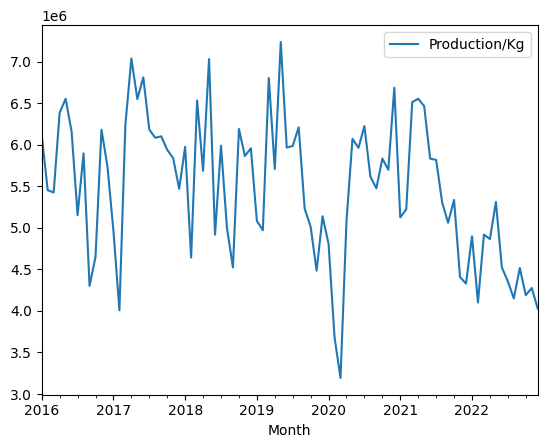

In [2]:
import pandas as pd
df=pd.read_csv('Arima_Rathnapura.csv', parse_dates=['Month'], index_col=['Month'])
df.info()

df.plot()

<Axes: xlabel='Month'>

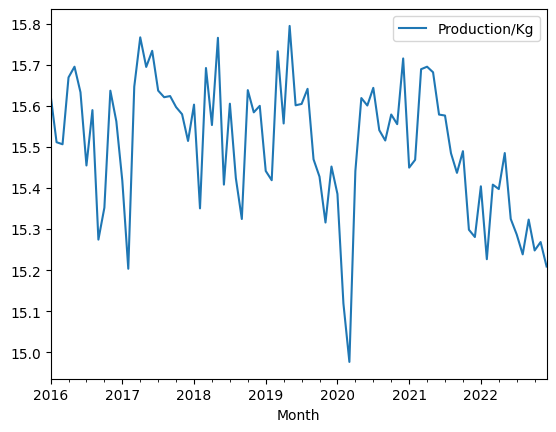

In [3]:
import numpy as np
df=np.log(df)

df.plot()

In [4]:
train=df[:50]
test=df[50:]

In [5]:
train.head()

,Production/Kg
Month,
2016-01-01,15.626138
2016-02-01,15.511520
2016-03-01,15.506447
2016-04-01,15.669221
2016-05-01,15.695297


In [6]:
test.head()

,Production/Kg
Month,
2020-03-01,14.976730
2020-04-01,15.441275
2020-05-01,15.618985
2020-06-01,15.600849
2020-07-01,15.643827


In [7]:
test.tail()

,Production/Kg
Month,
2022-08-01,15.238506
2022-09-01,15.323220
2022-10-01,15.248032
2022-11-01,15.268514
2022-12-01,15.208898


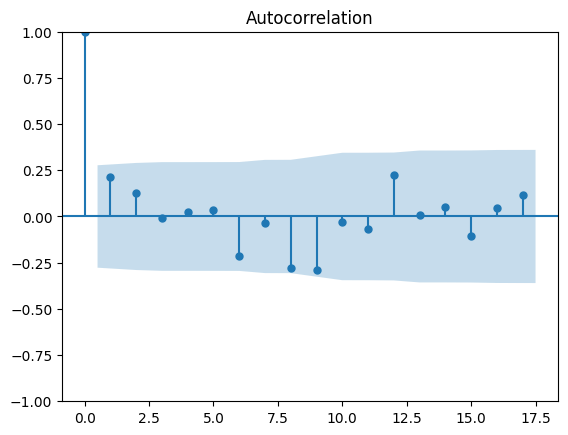

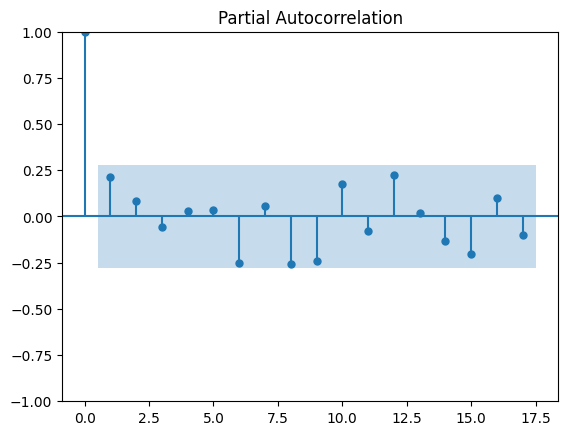

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(train)

pacf_original = plot_pacf(train)

In [9]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train)
print(f'p-value: {adf_test[1]}')

p-value: 0.014298968700361932


In [10]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(2,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          Production/Kg   No. Observations:                   50
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  23.663
Date:                Tue, 13 Aug 2024   AIC                            -39.327
Time:                        15:36:46   BIC                            -31.760
Sample:                    01-01-2016   HQIC                           -36.456
                         - 02-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2581      0.203      1.273      0.203      -0.139       0.656
ar.L2          0.1344      0.179      0.751      0.453      -0.216       0.485
ma.L1         -0.9753      0.282     -3.464      0.0

C:\Users\RANASINGHE\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\RANASINGHE\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\RANASINGHE\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\RANASINGHE\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive par

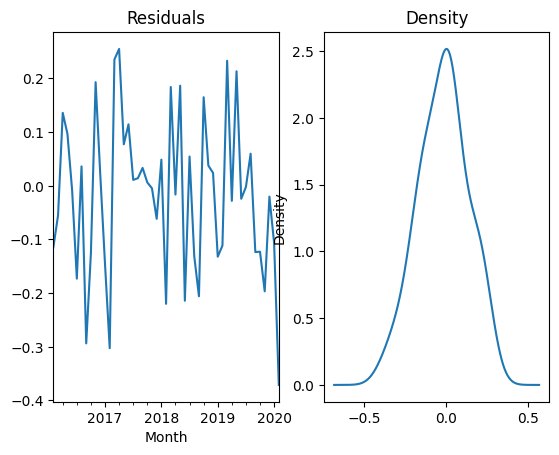

In [11]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

<Axes: xlabel='Month'>

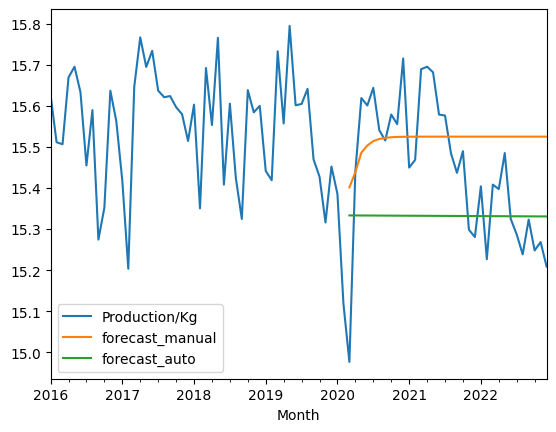

In [51]:
forecast_test = model_fit.forecast(len(test))

df['forecast_manual'] = [None]*len(train) + list(forecast_test)

df.plot()

In [47]:
import pmdarima as pm
auto_arima = pm.auto_arima(train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [52]:
auto_arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  18.575
Date:                Fri, 02 Aug 2024   AIC                            -31.150
Time:                        10:09:14   BIC                            -25.413
Sample:                    01-01-2016   HQIC                           -28.965
                         - 02-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   3161.740      0.000       0.999       1.001
ma.L1         -0.6797      0.125     -5.441      0.000      -0.925      -0.435
sigma2         0.0229      0.006      4.085      0.000       0.012       0.034
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.88   Prob(JB):                         0.64
Heteroskedasticity (H):               0.76   Skew:                             0.02
Prob(H) (two-sided):                  0.57   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Month'>

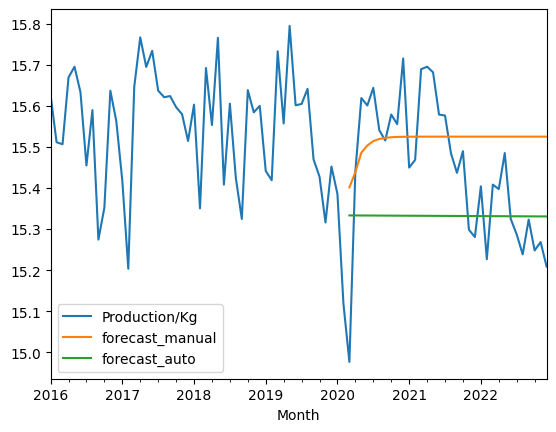

In [53]:
forecast_test_auto = auto_arima.predict(n_periods=len(test))
df['forecast_auto'] = [None]*len(train) + list(forecast_test_auto)

df.plot()

In [54]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(test, forecast_test)
mape = mean_absolute_percentage_error(test, forecast_test)
rmse = np.sqrt(mean_squared_error(test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 0.14516064934080147
mape - manual: 0.009450322311813194
rmse - manual: 0.17817041908028441


In [55]:
mae = mean_absolute_error(test, forecast_test_auto)
mape = mean_absolute_percentage_error(test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 0.1699036600980938
mape - auto: 0.010953341984348013
rmse - auto: 0.20330562622845455


In [56]:
forecast_test_auto.head()

2020-03-01    15.333326
2020-04-01    15.333251
2020-05-01    15.333176
2020-06-01    15.333100
2020-07-01    15.333025
Freq: MS, dtype: float64

In [57]:
forecast_test_auto.tail()

2022-08-01    15.331143
2022-09-01    15.331068
2022-10-01    15.330993
2022-11-01    15.330918
2022-12-01    15.330842
Freq: MS, dtype: float64

In [58]:
test.head()

,Production/Kg
Month,
2020-03-01,14.976730
2020-04-01,15.441275
2020-05-01,15.618985
2020-06-01,15.600849
2020-07-01,15.643827


In [59]:
train.head()

,Production/Kg
Month,
2016-01-01,15.626138
2016-02-01,15.511520
2016-03-01,15.506447
2016-04-01,15.669221
2016-05-01,15.695297


In [61]:
original_df = np.exp(df)


In [62]:
original_df.head()

,Production/Kg,forecast_manual,forecast_auto
Month,,,
2016-01-01,6114284.0,NaN,NaN
2016-02-01,5452146.0,NaN,NaN
2016-03-01,5424558.0,NaN,NaN
2016-04-01,6383458.0,NaN,NaN
2016-05-01,6552106.0,NaN,NaN


In [65]:
forecast_test.tail()

2022-08-01    15.525102
2022-09-01    15.525102
2022-10-01    15.525102
2022-11-01    15.525102
2022-12-01    15.525102
Freq: MS, Name: predicted_mean, dtype: float64

In [66]:
forecast_test.head()

2020-03-01    15.401500
2020-04-01    15.438618
2020-05-01    15.486168
2020-06-01    15.503430
2020-07-01    15.514276
Freq: MS, Name: predicted_mean, dtype: float64

In [69]:
test.head()

,Production/Kg
Month,
2020-03-01,14.976730
2020-04-01,15.441275
2020-05-01,15.618985
2020-06-01,15.600849
2020-07-01,15.643827


In [77]:
forecast_test

2020-03-01    15.401500
2020-04-01    15.438618
2020-05-01    15.486168
2020-06-01    15.503430
2020-07-01    15.514276
2020-08-01    15.519395
2020-09-01    15.522174
2020-10-01    15.523579
2020-11-01    15.524316
2020-12-01    15.524695
2021-01-01    15.524891
2021-02-01    15.524993
2021-03-01    15.525046
2021-04-01    15.525073
2021-05-01    15.525087
2021-06-01    15.525094
2021-07-01    15.525098
2021-08-01    15.525100
2021-09-01    15.525101
2021-10-01    15.525102
2021-11-01    15.525102
2021-12-01    15.525102
2022-01-01    15.525102
2022-02-01    15.525102
2022-03-01    15.525102
2022-04-01    15.525102
2022-05-01    15.525102
2022-06-01    15.525102
2022-07-01    15.525102
2022-08-01    15.525102
2022-09-01    15.525102
2022-10-01    15.525102
2022-11-01    15.525102
2022-12-01    15.525102
Freq: MS, Name: predicted_mean, dtype: float64

In [72]:
forecast_test_auto

2020-03-01    15.333326
2020-04-01    15.333251
2020-05-01    15.333176
2020-06-01    15.333100
2020-07-01    15.333025
2020-08-01    15.332950
2020-09-01    15.332875
2020-10-01    15.332799
2020-11-01    15.332724
2020-12-01    15.332649
2021-01-01    15.332574
2021-02-01    15.332498
2021-03-01    15.332423
2021-04-01    15.332348
2021-05-01    15.332272
2021-06-01    15.332197
2021-07-01    15.332122
2021-08-01    15.332047
2021-09-01    15.331971
2021-10-01    15.331896
2021-11-01    15.331821
2021-12-01    15.331746
2022-01-01    15.331670
2022-02-01    15.331595
2022-03-01    15.331520
2022-04-01    15.331444
2022-05-01    15.331369
2022-06-01    15.331294
2022-07-01    15.331219
2022-08-01    15.331143
2022-09-01    15.331068
2022-10-01    15.330993
2022-11-01    15.330918
2022-12-01    15.330842
Freq: MS, dtype: float64

In [73]:
train

,Production/Kg
Month,
2016-01-01,15.626138
2016-02-01,15.511520
2016-03-01,15.506447
2016-04-01,15.669221
2016-05-01,15.695297
2016-06-01,15.633052
2016-07-01,15.454881
2016-08-01,15.589635
2016-09-01,15.274449


In [74]:
test

,Production/Kg
Month,
2020-03-01,14.976730
2020-04-01,15.441275
2020-05-01,15.618985
2020-06-01,15.600849
2020-07-01,15.643827
2020-08-01,15.540816
2020-09-01,15.515693
2020-10-01,15.578916
2020-11-01,15.555413


In [81]:
# Predicting production for 2023
forecast_2023_manual = model_fit.forecast(steps=12)  # Assuming monthly data
forecast_2023_auto = auto_arima.predict(n_periods=12)

# Create a new DataFrame to hold the forecast
future_dates = pd.date_range(start='2023-01-01', periods=12, freq='MS')
forecast_2023_df = pd.DataFrame({'forecast_manual': forecast_2023_manual, 'forecast_auto': forecast_2023_auto}, index=future_dates)


